In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

%matplotlib inline

import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random

from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(device)

cpu


In [2]:
np.random.seed(1)
n_points = 500
y = np.concatenate((np.zeros(n_points),np.ones(n_points),np.ones(n_points)*2,np.ones(n_points)*3))#,np.ones(n_points)*4,
                    #np.ones(n_points)*5,np.ones(n_points)*6,np.ones(n_points)*7,np.ones(n_points)*8,np.ones(n_points)*9))
#y = np.random.randint(0,3,6000)
idx= []
for i in range(4):
    print(i,sum(y==i))
    idx.append(y==i)

0 500
1 500
2 500
3 500


In [3]:
x = np.zeros((n_points*4,5))


np.random.seed(1)
cov_mat = [[0.001,0,0,0,0],[0,0.001,0,0,0],[0,0.001,0,0,0],
                                                 [0,0,0,0.001,0],[0,0,0,0,0.001]]

x[idx[0],:] = np.random.multivariate_normal(mean = [1,0,0,0,0],
                                            cov=cov_mat,size=sum(idx[0]))


x[idx[1],:] = np.random.multivariate_normal(mean = [0,1,0,0,0],
                                            cov=cov_mat,size=sum(idx[1]))


x[idx[2],:] = np.random.multivariate_normal(mean = [0,0,1,0,0],
                                            cov=cov_mat,size=sum(idx[2]))


x[idx[3],:] = np.random.multivariate_normal(mean = [0,0,0,-0.75,0.5],
                                            cov=cov_mat,size=sum(idx[3]))



# x[idx[4],:] = np.random.multivariate_normal(mean = [0,0,0,0.65,-0.65],
#                                             cov=cov_mat,size=sum(idx[4]))


# x[idx[5],:] = np.random.multivariate_normal(mean = [0,0,0,-0.9,-0.75],
#                                             cov=cov_mat,size=sum(idx[5]))


# x[idx[6],:] = np.random.multivariate_normal(mean = [0,0,0,0.8,-0.8],
#                                             cov=cov_mat,size=sum(idx[6]))

# x[idx[7],:] = np.random.multivariate_normal(mean = [0,0,0,-0.5,0.8],
#                                             cov=cov_mat,size=sum(idx[7]))


# x[idx[8],:] = np.random.multivariate_normal(mean = [0,0,0,0.9,0.75],
#                                             cov=cov_mat,size=sum(idx[8]))


# x[idx[9],:] = np.random.multivariate_normal(mean = [0,0,0,-1,0.65],
#                                             cov=cov_mat,size=sum(idx[9]))

/var/folders/gl/27byknls1z5_v94kltf90q2h0000gn/T/ipykernel_62333/320880795.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  x[idx[0],:] = np.random.multivariate_normal(mean = [1,0,0,0,0],
/var/folders/gl/27byknls1z5_v94kltf90q2h0000gn/T/ipykernel_62333/320880795.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  x[idx[1],:] = np.random.multivariate_normal(mean = [0,1,0,0,0],
/var/folders/gl/27byknls1z5_v94kltf90q2h0000gn/T/ipykernel_62333/320880795.py:16: RuntimeWarning: covariance is not positive-semidefinite.
  x[idx[2],:] = np.random.multivariate_normal(mean = [0,0,1,0,0],
/var/folders/gl/27byknls1z5_v94kltf90q2h0000gn/T/ipykernel_62333/320880795.py:20: RuntimeWarning: covariance is not positive-semidefinite.
  x[idx[3],:] = np.random.multivariate_normal(mean = [0,0,0,-0.75,0.5],


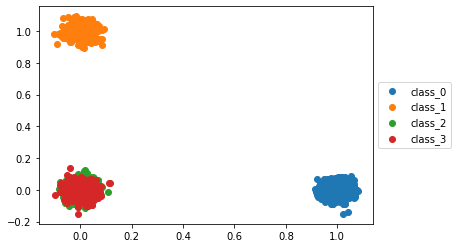

In [4]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [5]:
mean_x = np.mean(x,axis=0,keepdims=True)
std_x = np.std(x,axis=0,keepdims=True) 
x = ( x - mean_x  )  / std_x

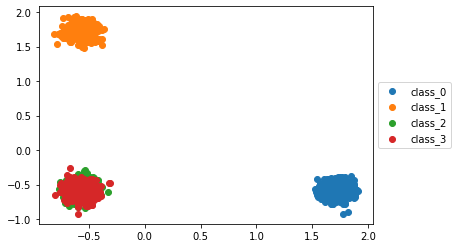

In [6]:
for i in range(4):
    plt.scatter(x[idx[i],0],x[idx[i],1],label="class_"+str(i))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [7]:
foreground_classes = {'class_0','class_1' }

background_classes = {'bg_classes',}

In [8]:
desired_num = 1100  # 2000 + 1000


m = 100



mosaic_list_of_images =[]
mosaic_label = []
fore_idx=[]
for j in tqdm(range(desired_num)):
    np.random.seed(j)
    fg_class  = np.random.randint(0,3)
    fg_idx = 0#np.random.randint(0,m)
    a = []
    for i in range(m):
        if i == fg_idx:
            b = np.random.choice(np.where(idx[fg_class]==True)[0],size=1)
            a.append(x[b])
#             print("foreground "+str(fg_class)+" present at " + str(fg_idx))
        else:
            bg_class = np.random.randint(3,4)
            b = np.random.choice(np.where(idx[bg_class]==True)[0],size=1)
            a.append(x[b])
#             print("background "+str(bg_class)+" present at " + str(i))
    a = np.concatenate(a,axis=0)
    mosaic_list_of_images.append(np.reshape(a,(m,5)))
    mosaic_label.append(fg_class)
    fore_idx.append(fg_idx)

100%|██████████████████████████████████████| 1100/1100 [00:02<00:00, 494.74it/s]


In [9]:
def create_sin_data(mosaic_dataset,labels,fg_n,m):
  """
  mosaic_dataset : mosaic_dataset contains 500 patches of dimendion 2 each as 1 data point
  labels : mosaic_dataset labels
  foreground_index : contains list of indexes where foreground image is present so that using this we can take weighted average
  """
  n_points = len(mosaic_dataset)
  patches = mosaic_dataset[0].shape[0]
  dims = mosaic_dataset[0].shape[1]
  img = np.zeros((n_points,patches,dims))

  for i in tqdm(range(len(mosaic_dataset))):
    for j in range(m):
      if j < fg_n:
        img[i][j] = mosaic_dataset[i][0]
      else:
        #print(j)
        index = np.random.randint(1,100,1)
        img[i][j]= mosaic_dataset[i][index]
    
    
  return  img,labels

In [10]:
tr = 100
avg_image_dataset_1 , labels_1 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],1,m)
avg_image_dataset_2 , labels_2 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],10,m)
avg_image_dataset_3 , labels_3 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],20,m)
avg_image_dataset_4, labels_4 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],30,m)
avg_image_dataset_5 , labels_5 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],40,m)
avg_image_dataset_6 , labels_6 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],50,m)
avg_image_dataset_7 , labels_7 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],60,m)
avg_image_dataset_8 , labels_8 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],70,m)
avg_image_dataset_9 , labels_9 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],80,m)
avg_image_dataset_10 , labels_10 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],90,m)
avg_image_dataset_11 , labels_11 = create_sin_data(mosaic_list_of_images[0:tr], mosaic_label[0:tr],100,m)
avg_image_dataset_12, labels_12 = create_sin_data(mosaic_list_of_images[tr:], mosaic_label[tr:],100,m)


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 17852.96it/s]


In [11]:
avg_image_dataset_1 = np.stack(avg_image_dataset_1)
avg_image_dataset_2 = np.stack(avg_image_dataset_2,axis=0)
avg_image_dataset_3 = np.stack(avg_image_dataset_3,axis=0)
avg_image_dataset_4 = np.stack(avg_image_dataset_4,axis=0)
avg_image_dataset_5 = np.stack(avg_image_dataset_5,axis=0)
avg_image_dataset_6 = np.stack(avg_image_dataset_6,axis=0)
avg_image_dataset_7 = np.stack(avg_image_dataset_7,axis=0)
avg_image_dataset_8 = np.stack(avg_image_dataset_8,axis=0)
avg_image_dataset_9 = np.stack(avg_image_dataset_9,axis=0)
avg_image_dataset_10 = np.stack(avg_image_dataset_10,axis=0)
avg_image_dataset_11 = np.stack(avg_image_dataset_11,axis=0)
avg_image_dataset_12 = np.stack(avg_image_dataset_12,axis=0)

In [12]:
avg_image_dataset_1.shape

(100, 100, 5)

In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] #, self.fore_idx[idx]

In [14]:
batch = 256


# training_data = avg_image_dataset_5    #just change this and training_label to desired dataset for training
# training_label = labels_5

traindata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
trainloader_1 = DataLoader( traindata_1 , batch_size= batch ,shuffle=True)

traindata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
trainloader_2 = DataLoader( traindata_2 , batch_size= batch ,shuffle=True)

traindata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
trainloader_3 = DataLoader( traindata_3 , batch_size= batch ,shuffle=True)

traindata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
trainloader_4 = DataLoader( traindata_4 , batch_size= batch ,shuffle=True)

traindata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
trainloader_5 = DataLoader( traindata_5 , batch_size= batch ,shuffle=True)

traindata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
trainloader_6 = DataLoader( traindata_6 , batch_size= batch ,shuffle=True)

traindata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
trainloader_7 = DataLoader( traindata_7 , batch_size= batch ,shuffle=True)

traindata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
trainloader_8 = DataLoader( traindata_8 , batch_size= batch ,shuffle=True)

traindata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
trainloader_9 = DataLoader( traindata_9 , batch_size= batch ,shuffle=True)


traindata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
trainloader_10 = DataLoader( traindata_10 , batch_size= batch ,shuffle=True)

traindata_11 = MosaicDataset(avg_image_dataset_11, labels_11)
trainloader_11 = DataLoader( traindata_11 , batch_size= batch ,shuffle=True)




testdata_1 = MosaicDataset(avg_image_dataset_1, labels_1 )
testloader_1 = DataLoader( testdata_1 , batch_size= batch ,shuffle=False)

testdata_2 = MosaicDataset(avg_image_dataset_2, labels_2 )
testloader_2 = DataLoader( testdata_2 , batch_size= batch ,shuffle=False)

testdata_3 = MosaicDataset(avg_image_dataset_3, labels_3 )
testloader_3 = DataLoader( testdata_3 , batch_size= batch ,shuffle=False)

testdata_4 = MosaicDataset(avg_image_dataset_4, labels_4 )
testloader_4 = DataLoader( testdata_4 , batch_size= batch ,shuffle=False)

testdata_5 = MosaicDataset(avg_image_dataset_5, labels_5 )
testloader_5 = DataLoader( testdata_5 , batch_size= batch ,shuffle=False)

testdata_6 = MosaicDataset(avg_image_dataset_6, labels_6 )
testloader_6 = DataLoader( testdata_6 , batch_size= batch ,shuffle=False)

testdata_7 = MosaicDataset(avg_image_dataset_7, labels_7 )
testloader_7 = DataLoader( testdata_7 , batch_size= batch ,shuffle=False)

testdata_8 = MosaicDataset(avg_image_dataset_8, labels_8 )
testloader_8 = DataLoader( testdata_8 , batch_size= batch ,shuffle=False)

testdata_9 = MosaicDataset(avg_image_dataset_9, labels_9 )
testloader_9 = DataLoader( testdata_9 , batch_size= batch ,shuffle=False)

testdata_10 = MosaicDataset(avg_image_dataset_10, labels_10 )
testloader_10 = DataLoader( testdata_10 , batch_size= batch ,shuffle=False)

testdata_11 = MosaicDataset(avg_image_dataset_11, labels_11 )
testloader_11 = DataLoader( testdata_11 , batch_size= batch ,shuffle=False)


testdata_12 = MosaicDataset(avg_image_dataset_12, labels_12 )
testloader_12 = DataLoader( testdata_12, batch_size= batch ,shuffle=False)



mosaicdata = MosaicDataset(mosaic_list_of_images[0:tr], mosaic_label[0:tr] )
mosaicloader = DataLoader( mosaicdata , batch_size= batch ,shuffle=True)




In [15]:
data,labels = iter(trainloader_1).next()

In [16]:
data.shape,labels.shape

(torch.Size([100, 100, 5]), torch.Size([100]))

In [17]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(5, 3)
    torch.nn.init.zeros_(self.fc1.weight)
    torch.nn.init.zeros_(self.fc1.bias)
  def forward(self, x):
    x = self.fc1(x)
    # print(x.shape)
    return x

In [18]:
def calculate_loss_alpha(mosaic_loader,alpha_,net,loss_criterion):
    m = 100
    
    loss_ = []
    with torch.no_grad():
        for i,data in enumerate(mosaic_loader):
            inputs,target =data
            outputs = net(inputs)
            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes))    
            target = target.repeat_interleave(patches)
            #print(outputs.shape,target.shape)
            loss = loss_criterion(outputs,target)
            
            loss = torch.reshape(loss,(batch,patches))
            
            loss_weight = torch.ones((batch,patches))*((1-alpha_)/(m-1))
            
            loss_weight[:,0] = alpha_
            
            loss = torch.mul(loss_weight,loss)
            
            loss = torch.sum(loss,dim=1)
            loss = torch.sum(loss,dim=0)
            
            loss_.append(loss.item()/batch)
    return np.mean(loss_)

In [19]:
def calculate_loss(trainloader,net,criterion):
    running_loss = 0.0
    ep_lossi = []
    with torch.no_grad():
        for k, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            running_loss += loss.item()
            ep_lossi.append(running_loss)
    return np.mean(ep_lossi)

In [20]:
def my_cross_entropy(output,target,loss_criterion):
    
    
    batch = output.size(0)
    #print(batch)
    patches = output.size(1)
    classes = output.size(2)
    output = torch.reshape(output,(batch*patches,classes))    
    target = target.repeat_interleave(patches)
    
    loss = loss_criterion(output,target)
    #print(final_loss)
    return loss

In [21]:
def test_all(number, testloader,net):
    correct = 0
    total = 0
    # out = []
    # pred = []
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device),labels.to(device)
            # out.append(labels.cpu().numpy())
            outputs= net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 

            _, predicted = torch.max(outputs.data, 1)
            # pred.append(predicted.cpu().numpy())
            labels = labels.repeat_interleave(patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test dataset %d: %d %%' % (number , 100 * correct / total))

In [22]:
def train_all(trainloader, ds_number, testloader_list,mosaicloader,alpha):
    
    print("--"*40)
    print("training on data set  ", ds_number)
    torch.manual_seed(12)
    net = Net().double()
    net = net.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.01)#, momentum=0.9)
    
    acti = []
    loss_curi = []
    
    loss_alpha_h_curi = []
    epochs = 1000
    
    criterion_ = nn.CrossEntropyLoss(reduction='none')
    if alpha ==1.0:
        alpha_ = alpha
    else:
        alpha_ = alpha+0.01
    for epoch in range(epochs): # loop over the dataset multiple times
        ep_lossi = []
        running_loss = 0.0
        if epoch == 0:    
                loss_curi.append(calculate_loss(trainloader,net,criterion))
        loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device),labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = my_cross_entropy(outputs, labels,criterion)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            mini = 1
            if i % mini == (mini-1):    
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / ( mini ) ))
                ep_lossi.append(running_loss/ (mini) ) # loss per minibatch
                running_loss = 0.0
                
        loss_curi.append(calculate_loss(trainloader,net,criterion))   #loss per epoch
    print('Finished Training')
    loss_alpha_h_curi.append( calculate_loss_alpha(mosaicloader,alpha_,net,criterion_))
    #torch.save(net.state_dict(),"train_dataset_"+str(ds_number)+"_"+str(epochs)+".pt")
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)

            batch = outputs.size(0)
            #print(batch)
            patches = outputs.size(1)
            classes = outputs.size(2)
            outputs = torch.reshape(outputs,(batch*patches,classes)) 
            
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.repeat_interleave(patches)
            #print(predicted.shape,labels.shape,patches)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the train images: %d %%' % (  100 * correct / total))
    

    for i, j in enumerate(testloader_list):
        test_all(i+1, j,net)
    
    print("--"*40)
    
    return loss_curi,loss_alpha_h_curi


In [23]:
train_loss_all=[]
train_loss_alpha_h_all = []

testloader_list= [ testloader_1, testloader_2, testloader_3, testloader_4, testloader_5, testloader_6,
                 testloader_7, testloader_8, testloader_9, testloader_10,testloader_11,testloader_12]


temp1,temp2 = train_all(trainloader_1, 1, testloader_list,mosaicloader,1/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_2, 2, testloader_list,mosaicloader,10/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_3, 3, testloader_list,mosaicloader,20/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_4, 4, testloader_list,mosaicloader,30/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_5, 5, testloader_list,mosaicloader,40/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_6, 6, testloader_list,mosaicloader,50/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_7, 7, testloader_list,mosaicloader,60/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_8, 8, testloader_list,mosaicloader,70/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_9, 9, testloader_list,mosaicloader,80/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)


temp1,temp2 = train_all(trainloader_10, 10, testloader_list,mosaicloader,90/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

temp1,temp2 = train_all(trainloader_11, 11, testloader_list,mosaicloader,100/100)
train_loss_all.append(temp1)
train_loss_alpha_h_all.append(temp2)

--------------------------------------------------------------------------------
training on data set   1
[1,     1] loss: 1.099
[2,     1] loss: 1.091
[3,     1] loss: 1.087
[4,     1] loss: 1.085
[5,     1] loss: 1.085
[6,     1] loss: 1.086
[7,     1] loss: 1.087
[8,     1] loss: 1.088
[9,     1] loss: 1.088
[10,     1] loss: 1.087
[11,     1] loss: 1.086
[12,     1] loss: 1.085
[13,     1] loss: 1.085
[14,     1] loss: 1.084
[15,     1] loss: 1.084
[16,     1] loss: 1.084
[17,     1] loss: 1.084
[18,     1] loss: 1.085
[19,     1] loss: 1.085
[20,     1] loss: 1.084
[21,     1] loss: 1.084
[22,     1] loss: 1.084
[23,     1] loss: 1.083
[24,     1] loss: 1.083
[25,     1] loss: 1.083
[26,     1] loss: 1.083
[27,     1] loss: 1.083
[28,     1] loss: 1.083
[29,     1] loss: 1.083
[30,     1] loss: 1.083
[31,     1] loss: 1.083
[32,     1] loss: 1.083
[33,     1] loss: 1.082
[34,     1] loss: 1.082
[35,     1] loss: 1.082
[36,     1] loss: 1.082
[37,     1] loss: 1.082
[38,     1] los

[329,     1] loss: 1.076
[330,     1] loss: 1.076
[331,     1] loss: 1.076
[332,     1] loss: 1.076
[333,     1] loss: 1.076
[334,     1] loss: 1.076
[335,     1] loss: 1.076
[336,     1] loss: 1.076
[337,     1] loss: 1.076
[338,     1] loss: 1.076
[339,     1] loss: 1.076
[340,     1] loss: 1.076
[341,     1] loss: 1.076
[342,     1] loss: 1.076
[343,     1] loss: 1.076
[344,     1] loss: 1.076
[345,     1] loss: 1.076
[346,     1] loss: 1.076
[347,     1] loss: 1.076
[348,     1] loss: 1.076
[349,     1] loss: 1.076
[350,     1] loss: 1.076
[351,     1] loss: 1.076
[352,     1] loss: 1.076
[353,     1] loss: 1.076
[354,     1] loss: 1.076
[355,     1] loss: 1.076
[356,     1] loss: 1.076
[357,     1] loss: 1.076
[358,     1] loss: 1.076
[359,     1] loss: 1.076
[360,     1] loss: 1.076
[361,     1] loss: 1.076
[362,     1] loss: 1.076
[363,     1] loss: 1.076
[364,     1] loss: 1.076
[365,     1] loss: 1.076
[366,     1] loss: 1.076
[367,     1] loss: 1.076
[368,     1] loss: 1.076


[672,     1] loss: 1.076
[673,     1] loss: 1.076
[674,     1] loss: 1.076
[675,     1] loss: 1.076
[676,     1] loss: 1.076
[677,     1] loss: 1.076
[678,     1] loss: 1.076
[679,     1] loss: 1.076
[680,     1] loss: 1.076
[681,     1] loss: 1.076
[682,     1] loss: 1.076
[683,     1] loss: 1.076
[684,     1] loss: 1.076
[685,     1] loss: 1.076
[686,     1] loss: 1.076
[687,     1] loss: 1.076
[688,     1] loss: 1.076
[689,     1] loss: 1.076
[690,     1] loss: 1.076
[691,     1] loss: 1.076
[692,     1] loss: 1.076
[693,     1] loss: 1.076
[694,     1] loss: 1.076
[695,     1] loss: 1.076
[696,     1] loss: 1.076
[697,     1] loss: 1.076
[698,     1] loss: 1.076
[699,     1] loss: 1.076
[700,     1] loss: 1.076
[701,     1] loss: 1.076
[702,     1] loss: 1.076
[703,     1] loss: 1.076
[704,     1] loss: 1.076
[705,     1] loss: 1.076
[706,     1] loss: 1.076
[707,     1] loss: 1.076
[708,     1] loss: 1.076
[709,     1] loss: 1.076
[710,     1] loss: 1.076
[711,     1] loss: 1.076


[30,     1] loss: 1.025
[31,     1] loss: 1.023
[32,     1] loss: 1.022
[33,     1] loss: 1.021
[34,     1] loss: 1.020
[35,     1] loss: 1.018
[36,     1] loss: 1.017
[37,     1] loss: 1.016
[38,     1] loss: 1.015
[39,     1] loss: 1.014
[40,     1] loss: 1.013
[41,     1] loss: 1.012
[42,     1] loss: 1.011
[43,     1] loss: 1.010
[44,     1] loss: 1.009
[45,     1] loss: 1.008
[46,     1] loss: 1.008
[47,     1] loss: 1.007
[48,     1] loss: 1.006
[49,     1] loss: 1.005
[50,     1] loss: 1.005
[51,     1] loss: 1.004
[52,     1] loss: 1.003
[53,     1] loss: 1.003
[54,     1] loss: 1.002
[55,     1] loss: 1.002
[56,     1] loss: 1.001
[57,     1] loss: 1.001
[58,     1] loss: 1.000
[59,     1] loss: 1.000
[60,     1] loss: 0.999
[61,     1] loss: 0.999
[62,     1] loss: 0.998
[63,     1] loss: 0.998
[64,     1] loss: 0.997
[65,     1] loss: 0.997
[66,     1] loss: 0.997
[67,     1] loss: 0.996
[68,     1] loss: 0.996
[69,     1] loss: 0.996
[70,     1] loss: 0.995
[71,     1] loss

[391,     1] loss: 0.983
[392,     1] loss: 0.983
[393,     1] loss: 0.983
[394,     1] loss: 0.983
[395,     1] loss: 0.983
[396,     1] loss: 0.983
[397,     1] loss: 0.983
[398,     1] loss: 0.983
[399,     1] loss: 0.983
[400,     1] loss: 0.983
[401,     1] loss: 0.983
[402,     1] loss: 0.983
[403,     1] loss: 0.983
[404,     1] loss: 0.983
[405,     1] loss: 0.983
[406,     1] loss: 0.983
[407,     1] loss: 0.983
[408,     1] loss: 0.983
[409,     1] loss: 0.983
[410,     1] loss: 0.983
[411,     1] loss: 0.983
[412,     1] loss: 0.983
[413,     1] loss: 0.983
[414,     1] loss: 0.983
[415,     1] loss: 0.983
[416,     1] loss: 0.983
[417,     1] loss: 0.983
[418,     1] loss: 0.983
[419,     1] loss: 0.983
[420,     1] loss: 0.983
[421,     1] loss: 0.983
[422,     1] loss: 0.983
[423,     1] loss: 0.983
[424,     1] loss: 0.983
[425,     1] loss: 0.983
[426,     1] loss: 0.983
[427,     1] loss: 0.983
[428,     1] loss: 0.983
[429,     1] loss: 0.983
[430,     1] loss: 0.983


[740,     1] loss: 0.982
[741,     1] loss: 0.982
[742,     1] loss: 0.982
[743,     1] loss: 0.982
[744,     1] loss: 0.982
[745,     1] loss: 0.982
[746,     1] loss: 0.982
[747,     1] loss: 0.982
[748,     1] loss: 0.982
[749,     1] loss: 0.982
[750,     1] loss: 0.982
[751,     1] loss: 0.982
[752,     1] loss: 0.982
[753,     1] loss: 0.982
[754,     1] loss: 0.982
[755,     1] loss: 0.982
[756,     1] loss: 0.982
[757,     1] loss: 0.982
[758,     1] loss: 0.982
[759,     1] loss: 0.982
[760,     1] loss: 0.982
[761,     1] loss: 0.982
[762,     1] loss: 0.982
[763,     1] loss: 0.982
[764,     1] loss: 0.982
[765,     1] loss: 0.982
[766,     1] loss: 0.982
[767,     1] loss: 0.982
[768,     1] loss: 0.982
[769,     1] loss: 0.982
[770,     1] loss: 0.982
[771,     1] loss: 0.982
[772,     1] loss: 0.982
[773,     1] loss: 0.982
[774,     1] loss: 0.982
[775,     1] loss: 0.982
[776,     1] loss: 0.982
[777,     1] loss: 0.982
[778,     1] loss: 0.982
[779,     1] loss: 0.982


[58,     1] loss: 0.910
[59,     1] loss: 0.909
[60,     1] loss: 0.908
[61,     1] loss: 0.908
[62,     1] loss: 0.907
[63,     1] loss: 0.906
[64,     1] loss: 0.905
[65,     1] loss: 0.904
[66,     1] loss: 0.904
[67,     1] loss: 0.903
[68,     1] loss: 0.902
[69,     1] loss: 0.902
[70,     1] loss: 0.901
[71,     1] loss: 0.900
[72,     1] loss: 0.900
[73,     1] loss: 0.899
[74,     1] loss: 0.899
[75,     1] loss: 0.898
[76,     1] loss: 0.898
[77,     1] loss: 0.897
[78,     1] loss: 0.897
[79,     1] loss: 0.896
[80,     1] loss: 0.896
[81,     1] loss: 0.895
[82,     1] loss: 0.895
[83,     1] loss: 0.895
[84,     1] loss: 0.894
[85,     1] loss: 0.894
[86,     1] loss: 0.893
[87,     1] loss: 0.893
[88,     1] loss: 0.893
[89,     1] loss: 0.892
[90,     1] loss: 0.892
[91,     1] loss: 0.892
[92,     1] loss: 0.891
[93,     1] loss: 0.891
[94,     1] loss: 0.891
[95,     1] loss: 0.891
[96,     1] loss: 0.890
[97,     1] loss: 0.890
[98,     1] loss: 0.890
[99,     1] loss

[422,     1] loss: 0.875
[423,     1] loss: 0.875
[424,     1] loss: 0.875
[425,     1] loss: 0.875
[426,     1] loss: 0.875
[427,     1] loss: 0.875
[428,     1] loss: 0.875
[429,     1] loss: 0.875
[430,     1] loss: 0.875
[431,     1] loss: 0.875
[432,     1] loss: 0.875
[433,     1] loss: 0.875
[434,     1] loss: 0.875
[435,     1] loss: 0.875
[436,     1] loss: 0.875
[437,     1] loss: 0.875
[438,     1] loss: 0.875
[439,     1] loss: 0.875
[440,     1] loss: 0.875
[441,     1] loss: 0.875
[442,     1] loss: 0.875
[443,     1] loss: 0.875
[444,     1] loss: 0.875
[445,     1] loss: 0.875
[446,     1] loss: 0.875
[447,     1] loss: 0.875
[448,     1] loss: 0.875
[449,     1] loss: 0.875
[450,     1] loss: 0.875
[451,     1] loss: 0.875
[452,     1] loss: 0.875
[453,     1] loss: 0.875
[454,     1] loss: 0.875
[455,     1] loss: 0.875
[456,     1] loss: 0.875
[457,     1] loss: 0.875
[458,     1] loss: 0.875
[459,     1] loss: 0.875
[460,     1] loss: 0.875
[461,     1] loss: 0.875


[780,     1] loss: 0.875
[781,     1] loss: 0.875
[782,     1] loss: 0.875
[783,     1] loss: 0.875
[784,     1] loss: 0.875
[785,     1] loss: 0.875
[786,     1] loss: 0.875
[787,     1] loss: 0.875
[788,     1] loss: 0.875
[789,     1] loss: 0.875
[790,     1] loss: 0.875
[791,     1] loss: 0.875
[792,     1] loss: 0.875
[793,     1] loss: 0.875
[794,     1] loss: 0.875
[795,     1] loss: 0.875
[796,     1] loss: 0.875
[797,     1] loss: 0.875
[798,     1] loss: 0.875
[799,     1] loss: 0.875
[800,     1] loss: 0.875
[801,     1] loss: 0.875
[802,     1] loss: 0.875
[803,     1] loss: 0.875
[804,     1] loss: 0.875
[805,     1] loss: 0.875
[806,     1] loss: 0.875
[807,     1] loss: 0.875
[808,     1] loss: 0.875
[809,     1] loss: 0.875
[810,     1] loss: 0.875
[811,     1] loss: 0.875
[812,     1] loss: 0.875
[813,     1] loss: 0.875
[814,     1] loss: 0.875
[815,     1] loss: 0.875
[816,     1] loss: 0.875
[817,     1] loss: 0.875
[818,     1] loss: 0.875
[819,     1] loss: 0.875


[79,     1] loss: 0.800
[80,     1] loss: 0.799
[81,     1] loss: 0.799
[82,     1] loss: 0.798
[83,     1] loss: 0.797
[84,     1] loss: 0.797
[85,     1] loss: 0.796
[86,     1] loss: 0.796
[87,     1] loss: 0.795
[88,     1] loss: 0.795
[89,     1] loss: 0.794
[90,     1] loss: 0.794
[91,     1] loss: 0.793
[92,     1] loss: 0.793
[93,     1] loss: 0.792
[94,     1] loss: 0.792
[95,     1] loss: 0.791
[96,     1] loss: 0.791
[97,     1] loss: 0.790
[98,     1] loss: 0.790
[99,     1] loss: 0.790
[100,     1] loss: 0.789
[101,     1] loss: 0.789
[102,     1] loss: 0.788
[103,     1] loss: 0.788
[104,     1] loss: 0.788
[105,     1] loss: 0.787
[106,     1] loss: 0.787
[107,     1] loss: 0.787
[108,     1] loss: 0.786
[109,     1] loss: 0.786
[110,     1] loss: 0.786
[111,     1] loss: 0.785
[112,     1] loss: 0.785
[113,     1] loss: 0.785
[114,     1] loss: 0.785
[115,     1] loss: 0.784
[116,     1] loss: 0.784
[117,     1] loss: 0.784
[118,     1] loss: 0.783
[119,     1] loss: 0.

[448,     1] loss: 0.767
[449,     1] loss: 0.767
[450,     1] loss: 0.767
[451,     1] loss: 0.767
[452,     1] loss: 0.767
[453,     1] loss: 0.767
[454,     1] loss: 0.767
[455,     1] loss: 0.767
[456,     1] loss: 0.767
[457,     1] loss: 0.767
[458,     1] loss: 0.767
[459,     1] loss: 0.767
[460,     1] loss: 0.767
[461,     1] loss: 0.767
[462,     1] loss: 0.767
[463,     1] loss: 0.767
[464,     1] loss: 0.767
[465,     1] loss: 0.767
[466,     1] loss: 0.767
[467,     1] loss: 0.767
[468,     1] loss: 0.767
[469,     1] loss: 0.767
[470,     1] loss: 0.767
[471,     1] loss: 0.767
[472,     1] loss: 0.767
[473,     1] loss: 0.767
[474,     1] loss: 0.767
[475,     1] loss: 0.767
[476,     1] loss: 0.767
[477,     1] loss: 0.767
[478,     1] loss: 0.767
[479,     1] loss: 0.767
[480,     1] loss: 0.767
[481,     1] loss: 0.767
[482,     1] loss: 0.767
[483,     1] loss: 0.767
[484,     1] loss: 0.767
[485,     1] loss: 0.767
[486,     1] loss: 0.767
[487,     1] loss: 0.767


[821,     1] loss: 0.765
[822,     1] loss: 0.765
[823,     1] loss: 0.765
[824,     1] loss: 0.765
[825,     1] loss: 0.765
[826,     1] loss: 0.765
[827,     1] loss: 0.765
[828,     1] loss: 0.765
[829,     1] loss: 0.765
[830,     1] loss: 0.765
[831,     1] loss: 0.765
[832,     1] loss: 0.765
[833,     1] loss: 0.765
[834,     1] loss: 0.765
[835,     1] loss: 0.765
[836,     1] loss: 0.765
[837,     1] loss: 0.765
[838,     1] loss: 0.765
[839,     1] loss: 0.765
[840,     1] loss: 0.765
[841,     1] loss: 0.765
[842,     1] loss: 0.765
[843,     1] loss: 0.765
[844,     1] loss: 0.765
[845,     1] loss: 0.765
[846,     1] loss: 0.765
[847,     1] loss: 0.765
[848,     1] loss: 0.765
[849,     1] loss: 0.765
[850,     1] loss: 0.765
[851,     1] loss: 0.765
[852,     1] loss: 0.765
[853,     1] loss: 0.765
[854,     1] loss: 0.765
[855,     1] loss: 0.765
[856,     1] loss: 0.765
[857,     1] loss: 0.765
[858,     1] loss: 0.765
[859,     1] loss: 0.765
[860,     1] loss: 0.765


[142,     1] loss: 0.675
[143,     1] loss: 0.675
[144,     1] loss: 0.675
[145,     1] loss: 0.675
[146,     1] loss: 0.674
[147,     1] loss: 0.674
[148,     1] loss: 0.674
[149,     1] loss: 0.674
[150,     1] loss: 0.674
[151,     1] loss: 0.673
[152,     1] loss: 0.673
[153,     1] loss: 0.673
[154,     1] loss: 0.673
[155,     1] loss: 0.673
[156,     1] loss: 0.673
[157,     1] loss: 0.672
[158,     1] loss: 0.672
[159,     1] loss: 0.672
[160,     1] loss: 0.672
[161,     1] loss: 0.672
[162,     1] loss: 0.672
[163,     1] loss: 0.671
[164,     1] loss: 0.671
[165,     1] loss: 0.671
[166,     1] loss: 0.671
[167,     1] loss: 0.671
[168,     1] loss: 0.671
[169,     1] loss: 0.670
[170,     1] loss: 0.670
[171,     1] loss: 0.670
[172,     1] loss: 0.670
[173,     1] loss: 0.670
[174,     1] loss: 0.670
[175,     1] loss: 0.670
[176,     1] loss: 0.670
[177,     1] loss: 0.669
[178,     1] loss: 0.669
[179,     1] loss: 0.669
[180,     1] loss: 0.669
[181,     1] loss: 0.669


[517,     1] loss: 0.658
[518,     1] loss: 0.658
[519,     1] loss: 0.658
[520,     1] loss: 0.658
[521,     1] loss: 0.658
[522,     1] loss: 0.658
[523,     1] loss: 0.658
[524,     1] loss: 0.658
[525,     1] loss: 0.658
[526,     1] loss: 0.658
[527,     1] loss: 0.658
[528,     1] loss: 0.658
[529,     1] loss: 0.658
[530,     1] loss: 0.658
[531,     1] loss: 0.658
[532,     1] loss: 0.658
[533,     1] loss: 0.658
[534,     1] loss: 0.658
[535,     1] loss: 0.658
[536,     1] loss: 0.658
[537,     1] loss: 0.658
[538,     1] loss: 0.658
[539,     1] loss: 0.658
[540,     1] loss: 0.658
[541,     1] loss: 0.658
[542,     1] loss: 0.658
[543,     1] loss: 0.658
[544,     1] loss: 0.658
[545,     1] loss: 0.658
[546,     1] loss: 0.658
[547,     1] loss: 0.658
[548,     1] loss: 0.658
[549,     1] loss: 0.658
[550,     1] loss: 0.658
[551,     1] loss: 0.658
[552,     1] loss: 0.658
[553,     1] loss: 0.658
[554,     1] loss: 0.658
[555,     1] loss: 0.658
[556,     1] loss: 0.658


[887,     1] loss: 0.657
[888,     1] loss: 0.657
[889,     1] loss: 0.657
[890,     1] loss: 0.657
[891,     1] loss: 0.657
[892,     1] loss: 0.657
[893,     1] loss: 0.657
[894,     1] loss: 0.657
[895,     1] loss: 0.657
[896,     1] loss: 0.657
[897,     1] loss: 0.657
[898,     1] loss: 0.657
[899,     1] loss: 0.657
[900,     1] loss: 0.657
[901,     1] loss: 0.657
[902,     1] loss: 0.657
[903,     1] loss: 0.657
[904,     1] loss: 0.657
[905,     1] loss: 0.657
[906,     1] loss: 0.657
[907,     1] loss: 0.657
[908,     1] loss: 0.657
[909,     1] loss: 0.657
[910,     1] loss: 0.657
[911,     1] loss: 0.657
[912,     1] loss: 0.657
[913,     1] loss: 0.657
[914,     1] loss: 0.657
[915,     1] loss: 0.657
[916,     1] loss: 0.657
[917,     1] loss: 0.657
[918,     1] loss: 0.657
[919,     1] loss: 0.657
[920,     1] loss: 0.657
[921,     1] loss: 0.657
[922,     1] loss: 0.657
[923,     1] loss: 0.657
[924,     1] loss: 0.657
[925,     1] loss: 0.657
[926,     1] loss: 0.657


[203,     1] loss: 0.561
[204,     1] loss: 0.561
[205,     1] loss: 0.561
[206,     1] loss: 0.561
[207,     1] loss: 0.561
[208,     1] loss: 0.561
[209,     1] loss: 0.561
[210,     1] loss: 0.561
[211,     1] loss: 0.561
[212,     1] loss: 0.560
[213,     1] loss: 0.560
[214,     1] loss: 0.560
[215,     1] loss: 0.560
[216,     1] loss: 0.560
[217,     1] loss: 0.560
[218,     1] loss: 0.560
[219,     1] loss: 0.560
[220,     1] loss: 0.560
[221,     1] loss: 0.560
[222,     1] loss: 0.559
[223,     1] loss: 0.559
[224,     1] loss: 0.559
[225,     1] loss: 0.559
[226,     1] loss: 0.559
[227,     1] loss: 0.559
[228,     1] loss: 0.559
[229,     1] loss: 0.559
[230,     1] loss: 0.559
[231,     1] loss: 0.559
[232,     1] loss: 0.559
[233,     1] loss: 0.559
[234,     1] loss: 0.558
[235,     1] loss: 0.558
[236,     1] loss: 0.558
[237,     1] loss: 0.558
[238,     1] loss: 0.558
[239,     1] loss: 0.558
[240,     1] loss: 0.558
[241,     1] loss: 0.558
[242,     1] loss: 0.558


[571,     1] loss: 0.550
[572,     1] loss: 0.550
[573,     1] loss: 0.550
[574,     1] loss: 0.550
[575,     1] loss: 0.550
[576,     1] loss: 0.550
[577,     1] loss: 0.550
[578,     1] loss: 0.550
[579,     1] loss: 0.550
[580,     1] loss: 0.550
[581,     1] loss: 0.550
[582,     1] loss: 0.550
[583,     1] loss: 0.550
[584,     1] loss: 0.550
[585,     1] loss: 0.550
[586,     1] loss: 0.550
[587,     1] loss: 0.550
[588,     1] loss: 0.550
[589,     1] loss: 0.550
[590,     1] loss: 0.550
[591,     1] loss: 0.550
[592,     1] loss: 0.550
[593,     1] loss: 0.550
[594,     1] loss: 0.550
[595,     1] loss: 0.550
[596,     1] loss: 0.550
[597,     1] loss: 0.550
[598,     1] loss: 0.550
[599,     1] loss: 0.550
[600,     1] loss: 0.550
[601,     1] loss: 0.550
[602,     1] loss: 0.550
[603,     1] loss: 0.550
[604,     1] loss: 0.550
[605,     1] loss: 0.550
[606,     1] loss: 0.550
[607,     1] loss: 0.550
[608,     1] loss: 0.550
[609,     1] loss: 0.550
[610,     1] loss: 0.550


[940,     1] loss: 0.548
[941,     1] loss: 0.548
[942,     1] loss: 0.548
[943,     1] loss: 0.548
[944,     1] loss: 0.548
[945,     1] loss: 0.548
[946,     1] loss: 0.548
[947,     1] loss: 0.548
[948,     1] loss: 0.548
[949,     1] loss: 0.548
[950,     1] loss: 0.548
[951,     1] loss: 0.548
[952,     1] loss: 0.548
[953,     1] loss: 0.548
[954,     1] loss: 0.548
[955,     1] loss: 0.548
[956,     1] loss: 0.548
[957,     1] loss: 0.548
[958,     1] loss: 0.548
[959,     1] loss: 0.548
[960,     1] loss: 0.548
[961,     1] loss: 0.548
[962,     1] loss: 0.548
[963,     1] loss: 0.548
[964,     1] loss: 0.548
[965,     1] loss: 0.548
[966,     1] loss: 0.548
[967,     1] loss: 0.548
[968,     1] loss: 0.548
[969,     1] loss: 0.548
[970,     1] loss: 0.548
[971,     1] loss: 0.548
[972,     1] loss: 0.548
[973,     1] loss: 0.548
[974,     1] loss: 0.548
[975,     1] loss: 0.548
[976,     1] loss: 0.548
[977,     1] loss: 0.548
[978,     1] loss: 0.548
[979,     1] loss: 0.548


[263,     1] loss: 0.450
[264,     1] loss: 0.450
[265,     1] loss: 0.450
[266,     1] loss: 0.450
[267,     1] loss: 0.450
[268,     1] loss: 0.450
[269,     1] loss: 0.450
[270,     1] loss: 0.449
[271,     1] loss: 0.449
[272,     1] loss: 0.449
[273,     1] loss: 0.449
[274,     1] loss: 0.449
[275,     1] loss: 0.449
[276,     1] loss: 0.449
[277,     1] loss: 0.449
[278,     1] loss: 0.449
[279,     1] loss: 0.449
[280,     1] loss: 0.449
[281,     1] loss: 0.449
[282,     1] loss: 0.449
[283,     1] loss: 0.449
[284,     1] loss: 0.449
[285,     1] loss: 0.449
[286,     1] loss: 0.448
[287,     1] loss: 0.448
[288,     1] loss: 0.448
[289,     1] loss: 0.448
[290,     1] loss: 0.448
[291,     1] loss: 0.448
[292,     1] loss: 0.448
[293,     1] loss: 0.448
[294,     1] loss: 0.448
[295,     1] loss: 0.448
[296,     1] loss: 0.448
[297,     1] loss: 0.448
[298,     1] loss: 0.448
[299,     1] loss: 0.448
[300,     1] loss: 0.448
[301,     1] loss: 0.448
[302,     1] loss: 0.448


[633,     1] loss: 0.441
[634,     1] loss: 0.441
[635,     1] loss: 0.441
[636,     1] loss: 0.441
[637,     1] loss: 0.441
[638,     1] loss: 0.441
[639,     1] loss: 0.441
[640,     1] loss: 0.441
[641,     1] loss: 0.441
[642,     1] loss: 0.441
[643,     1] loss: 0.441
[644,     1] loss: 0.441
[645,     1] loss: 0.441
[646,     1] loss: 0.441
[647,     1] loss: 0.441
[648,     1] loss: 0.441
[649,     1] loss: 0.441
[650,     1] loss: 0.441
[651,     1] loss: 0.441
[652,     1] loss: 0.441
[653,     1] loss: 0.441
[654,     1] loss: 0.441
[655,     1] loss: 0.441
[656,     1] loss: 0.441
[657,     1] loss: 0.441
[658,     1] loss: 0.441
[659,     1] loss: 0.441
[660,     1] loss: 0.441
[661,     1] loss: 0.441
[662,     1] loss: 0.441
[663,     1] loss: 0.441
[664,     1] loss: 0.441
[665,     1] loss: 0.441
[666,     1] loss: 0.441
[667,     1] loss: 0.441
[668,     1] loss: 0.441
[669,     1] loss: 0.441
[670,     1] loss: 0.441
[671,     1] loss: 0.441
[672,     1] loss: 0.441


[977,     1] loss: 0.440
[978,     1] loss: 0.440
[979,     1] loss: 0.440
[980,     1] loss: 0.440
[981,     1] loss: 0.440
[982,     1] loss: 0.440
[983,     1] loss: 0.440
[984,     1] loss: 0.440
[985,     1] loss: 0.440
[986,     1] loss: 0.440
[987,     1] loss: 0.440
[988,     1] loss: 0.440
[989,     1] loss: 0.440
[990,     1] loss: 0.440
[991,     1] loss: 0.440
[992,     1] loss: 0.440
[993,     1] loss: 0.440
[994,     1] loss: 0.440
[995,     1] loss: 0.440
[996,     1] loss: 0.440
[997,     1] loss: 0.440
[998,     1] loss: 0.440
[999,     1] loss: 0.440
[1000,     1] loss: 0.440
Finished Training
Accuracy of the network on the train images: 75 %
Accuracy of the network on the test dataset 1: 37 %
Accuracy of the network on the test dataset 2: 43 %
Accuracy of the network on the test dataset 3: 49 %
Accuracy of the network on the test dataset 4: 56 %
Accuracy of the network on the test dataset 5: 62 %
Accuracy of the network on the test dataset 6: 68 %
Accuracy of the net

[293,     1] loss: 0.340
[294,     1] loss: 0.340
[295,     1] loss: 0.339
[296,     1] loss: 0.339
[297,     1] loss: 0.339
[298,     1] loss: 0.339
[299,     1] loss: 0.339
[300,     1] loss: 0.339
[301,     1] loss: 0.339
[302,     1] loss: 0.339
[303,     1] loss: 0.339
[304,     1] loss: 0.339
[305,     1] loss: 0.339
[306,     1] loss: 0.339
[307,     1] loss: 0.339
[308,     1] loss: 0.339
[309,     1] loss: 0.339
[310,     1] loss: 0.339
[311,     1] loss: 0.338
[312,     1] loss: 0.338
[313,     1] loss: 0.338
[314,     1] loss: 0.338
[315,     1] loss: 0.338
[316,     1] loss: 0.338
[317,     1] loss: 0.338
[318,     1] loss: 0.338
[319,     1] loss: 0.338
[320,     1] loss: 0.338
[321,     1] loss: 0.338
[322,     1] loss: 0.338
[323,     1] loss: 0.338
[324,     1] loss: 0.338
[325,     1] loss: 0.338
[326,     1] loss: 0.338
[327,     1] loss: 0.338
[328,     1] loss: 0.338
[329,     1] loss: 0.338
[330,     1] loss: 0.337
[331,     1] loss: 0.337
[332,     1] loss: 0.337


[658,     1] loss: 0.331
[659,     1] loss: 0.331
[660,     1] loss: 0.331
[661,     1] loss: 0.331
[662,     1] loss: 0.331
[663,     1] loss: 0.330
[664,     1] loss: 0.330
[665,     1] loss: 0.330
[666,     1] loss: 0.330
[667,     1] loss: 0.330
[668,     1] loss: 0.330
[669,     1] loss: 0.330
[670,     1] loss: 0.330
[671,     1] loss: 0.330
[672,     1] loss: 0.330
[673,     1] loss: 0.330
[674,     1] loss: 0.330
[675,     1] loss: 0.330
[676,     1] loss: 0.330
[677,     1] loss: 0.330
[678,     1] loss: 0.330
[679,     1] loss: 0.330
[680,     1] loss: 0.330
[681,     1] loss: 0.330
[682,     1] loss: 0.330
[683,     1] loss: 0.330
[684,     1] loss: 0.330
[685,     1] loss: 0.330
[686,     1] loss: 0.330
[687,     1] loss: 0.330
[688,     1] loss: 0.330
[689,     1] loss: 0.330
[690,     1] loss: 0.330
[691,     1] loss: 0.330
[692,     1] loss: 0.330
[693,     1] loss: 0.330
[694,     1] loss: 0.330
[695,     1] loss: 0.330
[696,     1] loss: 0.330
[697,     1] loss: 0.330


[20,     1] loss: 0.701
[21,     1] loss: 0.686
[22,     1] loss: 0.671
[23,     1] loss: 0.657
[24,     1] loss: 0.643
[25,     1] loss: 0.629
[26,     1] loss: 0.616
[27,     1] loss: 0.604
[28,     1] loss: 0.592
[29,     1] loss: 0.580
[30,     1] loss: 0.569
[31,     1] loss: 0.558
[32,     1] loss: 0.547
[33,     1] loss: 0.537
[34,     1] loss: 0.528
[35,     1] loss: 0.518
[36,     1] loss: 0.509
[37,     1] loss: 0.501
[38,     1] loss: 0.492
[39,     1] loss: 0.484
[40,     1] loss: 0.476
[41,     1] loss: 0.469
[42,     1] loss: 0.462
[43,     1] loss: 0.455
[44,     1] loss: 0.448
[45,     1] loss: 0.442
[46,     1] loss: 0.436
[47,     1] loss: 0.430
[48,     1] loss: 0.424
[49,     1] loss: 0.419
[50,     1] loss: 0.414
[51,     1] loss: 0.409
[52,     1] loss: 0.404
[53,     1] loss: 0.399
[54,     1] loss: 0.395
[55,     1] loss: 0.390
[56,     1] loss: 0.386
[57,     1] loss: 0.382
[58,     1] loss: 0.378
[59,     1] loss: 0.375
[60,     1] loss: 0.371
[61,     1] loss

[391,     1] loss: 0.229
[392,     1] loss: 0.229
[393,     1] loss: 0.229
[394,     1] loss: 0.229
[395,     1] loss: 0.229
[396,     1] loss: 0.229
[397,     1] loss: 0.229
[398,     1] loss: 0.228
[399,     1] loss: 0.228
[400,     1] loss: 0.228
[401,     1] loss: 0.228
[402,     1] loss: 0.228
[403,     1] loss: 0.228
[404,     1] loss: 0.228
[405,     1] loss: 0.228
[406,     1] loss: 0.228
[407,     1] loss: 0.228
[408,     1] loss: 0.228
[409,     1] loss: 0.228
[410,     1] loss: 0.228
[411,     1] loss: 0.228
[412,     1] loss: 0.228
[413,     1] loss: 0.228
[414,     1] loss: 0.228
[415,     1] loss: 0.228
[416,     1] loss: 0.228
[417,     1] loss: 0.228
[418,     1] loss: 0.228
[419,     1] loss: 0.228
[420,     1] loss: 0.228
[421,     1] loss: 0.228
[422,     1] loss: 0.228
[423,     1] loss: 0.228
[424,     1] loss: 0.228
[425,     1] loss: 0.228
[426,     1] loss: 0.228
[427,     1] loss: 0.228
[428,     1] loss: 0.228
[429,     1] loss: 0.227
[430,     1] loss: 0.227


[757,     1] loss: 0.223
[758,     1] loss: 0.223
[759,     1] loss: 0.223
[760,     1] loss: 0.223
[761,     1] loss: 0.223
[762,     1] loss: 0.223
[763,     1] loss: 0.223
[764,     1] loss: 0.223
[765,     1] loss: 0.223
[766,     1] loss: 0.223
[767,     1] loss: 0.223
[768,     1] loss: 0.223
[769,     1] loss: 0.223
[770,     1] loss: 0.223
[771,     1] loss: 0.223
[772,     1] loss: 0.223
[773,     1] loss: 0.223
[774,     1] loss: 0.223
[775,     1] loss: 0.223
[776,     1] loss: 0.223
[777,     1] loss: 0.223
[778,     1] loss: 0.223
[779,     1] loss: 0.223
[780,     1] loss: 0.223
[781,     1] loss: 0.223
[782,     1] loss: 0.223
[783,     1] loss: 0.223
[784,     1] loss: 0.223
[785,     1] loss: 0.223
[786,     1] loss: 0.223
[787,     1] loss: 0.223
[788,     1] loss: 0.223
[789,     1] loss: 0.223
[790,     1] loss: 0.223
[791,     1] loss: 0.223
[792,     1] loss: 0.223
[793,     1] loss: 0.223
[794,     1] loss: 0.223
[795,     1] loss: 0.223
[796,     1] loss: 0.223


[96,     1] loss: 0.198
[97,     1] loss: 0.196
[98,     1] loss: 0.195
[99,     1] loss: 0.194
[100,     1] loss: 0.193
[101,     1] loss: 0.191
[102,     1] loss: 0.190
[103,     1] loss: 0.189
[104,     1] loss: 0.188
[105,     1] loss: 0.187
[106,     1] loss: 0.186
[107,     1] loss: 0.185
[108,     1] loss: 0.184
[109,     1] loss: 0.183
[110,     1] loss: 0.182
[111,     1] loss: 0.181
[112,     1] loss: 0.180
[113,     1] loss: 0.179
[114,     1] loss: 0.178
[115,     1] loss: 0.177
[116,     1] loss: 0.177
[117,     1] loss: 0.176
[118,     1] loss: 0.175
[119,     1] loss: 0.174
[120,     1] loss: 0.173
[121,     1] loss: 0.173
[122,     1] loss: 0.172
[123,     1] loss: 0.171
[124,     1] loss: 0.170
[125,     1] loss: 0.170
[126,     1] loss: 0.169
[127,     1] loss: 0.168
[128,     1] loss: 0.168
[129,     1] loss: 0.167
[130,     1] loss: 0.166
[131,     1] loss: 0.166
[132,     1] loss: 0.165
[133,     1] loss: 0.165
[134,     1] loss: 0.164
[135,     1] loss: 0.163
[136

[463,     1] loss: 0.118
[464,     1] loss: 0.118
[465,     1] loss: 0.118
[466,     1] loss: 0.118
[467,     1] loss: 0.118
[468,     1] loss: 0.118
[469,     1] loss: 0.118
[470,     1] loss: 0.118
[471,     1] loss: 0.118
[472,     1] loss: 0.118
[473,     1] loss: 0.118
[474,     1] loss: 0.118
[475,     1] loss: 0.118
[476,     1] loss: 0.118
[477,     1] loss: 0.118
[478,     1] loss: 0.118
[479,     1] loss: 0.118
[480,     1] loss: 0.118
[481,     1] loss: 0.118
[482,     1] loss: 0.118
[483,     1] loss: 0.118
[484,     1] loss: 0.118
[485,     1] loss: 0.118
[486,     1] loss: 0.118
[487,     1] loss: 0.118
[488,     1] loss: 0.118
[489,     1] loss: 0.118
[490,     1] loss: 0.117
[491,     1] loss: 0.117
[492,     1] loss: 0.117
[493,     1] loss: 0.117
[494,     1] loss: 0.117
[495,     1] loss: 0.117
[496,     1] loss: 0.117
[497,     1] loss: 0.117
[498,     1] loss: 0.117
[499,     1] loss: 0.117
[500,     1] loss: 0.117
[501,     1] loss: 0.117
[502,     1] loss: 0.117


[816,     1] loss: 0.113
[817,     1] loss: 0.113
[818,     1] loss: 0.113
[819,     1] loss: 0.113
[820,     1] loss: 0.113
[821,     1] loss: 0.113
[822,     1] loss: 0.113
[823,     1] loss: 0.113
[824,     1] loss: 0.113
[825,     1] loss: 0.113
[826,     1] loss: 0.113
[827,     1] loss: 0.113
[828,     1] loss: 0.113
[829,     1] loss: 0.113
[830,     1] loss: 0.113
[831,     1] loss: 0.113
[832,     1] loss: 0.113
[833,     1] loss: 0.113
[834,     1] loss: 0.113
[835,     1] loss: 0.113
[836,     1] loss: 0.113
[837,     1] loss: 0.113
[838,     1] loss: 0.113
[839,     1] loss: 0.113
[840,     1] loss: 0.113
[841,     1] loss: 0.113
[842,     1] loss: 0.113
[843,     1] loss: 0.113
[844,     1] loss: 0.113
[845,     1] loss: 0.113
[846,     1] loss: 0.113
[847,     1] loss: 0.113
[848,     1] loss: 0.113
[849,     1] loss: 0.113
[850,     1] loss: 0.113
[851,     1] loss: 0.113
[852,     1] loss: 0.113
[853,     1] loss: 0.113
[854,     1] loss: 0.113
[855,     1] loss: 0.113


[138,     1] loss: 0.059
[139,     1] loss: 0.058
[140,     1] loss: 0.057
[141,     1] loss: 0.057
[142,     1] loss: 0.056
[143,     1] loss: 0.056
[144,     1] loss: 0.055
[145,     1] loss: 0.055
[146,     1] loss: 0.054
[147,     1] loss: 0.054
[148,     1] loss: 0.053
[149,     1] loss: 0.052
[150,     1] loss: 0.052
[151,     1] loss: 0.051
[152,     1] loss: 0.051
[153,     1] loss: 0.051
[154,     1] loss: 0.050
[155,     1] loss: 0.050
[156,     1] loss: 0.049
[157,     1] loss: 0.049
[158,     1] loss: 0.048
[159,     1] loss: 0.048
[160,     1] loss: 0.047
[161,     1] loss: 0.047
[162,     1] loss: 0.047
[163,     1] loss: 0.046
[164,     1] loss: 0.046
[165,     1] loss: 0.045
[166,     1] loss: 0.045
[167,     1] loss: 0.044
[168,     1] loss: 0.044
[169,     1] loss: 0.044
[170,     1] loss: 0.043
[171,     1] loss: 0.043
[172,     1] loss: 0.043
[173,     1] loss: 0.042
[174,     1] loss: 0.042
[175,     1] loss: 0.042
[176,     1] loss: 0.041
[177,     1] loss: 0.041


[499,     1] loss: 0.009
[500,     1] loss: 0.009
[501,     1] loss: 0.009
[502,     1] loss: 0.009
[503,     1] loss: 0.009
[504,     1] loss: 0.009
[505,     1] loss: 0.009
[506,     1] loss: 0.009
[507,     1] loss: 0.008
[508,     1] loss: 0.008
[509,     1] loss: 0.008
[510,     1] loss: 0.008
[511,     1] loss: 0.008
[512,     1] loss: 0.008
[513,     1] loss: 0.008
[514,     1] loss: 0.008
[515,     1] loss: 0.008
[516,     1] loss: 0.008
[517,     1] loss: 0.008
[518,     1] loss: 0.008
[519,     1] loss: 0.008
[520,     1] loss: 0.008
[521,     1] loss: 0.008
[522,     1] loss: 0.008
[523,     1] loss: 0.008
[524,     1] loss: 0.008
[525,     1] loss: 0.008
[526,     1] loss: 0.008
[527,     1] loss: 0.008
[528,     1] loss: 0.008
[529,     1] loss: 0.008
[530,     1] loss: 0.008
[531,     1] loss: 0.008
[532,     1] loss: 0.008
[533,     1] loss: 0.008
[534,     1] loss: 0.008
[535,     1] loss: 0.008
[536,     1] loss: 0.008
[537,     1] loss: 0.008
[538,     1] loss: 0.008


[864,     1] loss: 0.004
[865,     1] loss: 0.004
[866,     1] loss: 0.004
[867,     1] loss: 0.004
[868,     1] loss: 0.004
[869,     1] loss: 0.004
[870,     1] loss: 0.004
[871,     1] loss: 0.004
[872,     1] loss: 0.004
[873,     1] loss: 0.004
[874,     1] loss: 0.004
[875,     1] loss: 0.004
[876,     1] loss: 0.004
[877,     1] loss: 0.004
[878,     1] loss: 0.004
[879,     1] loss: 0.004
[880,     1] loss: 0.004
[881,     1] loss: 0.004
[882,     1] loss: 0.004
[883,     1] loss: 0.004
[884,     1] loss: 0.004
[885,     1] loss: 0.004
[886,     1] loss: 0.004
[887,     1] loss: 0.004
[888,     1] loss: 0.003
[889,     1] loss: 0.003
[890,     1] loss: 0.003
[891,     1] loss: 0.003
[892,     1] loss: 0.003
[893,     1] loss: 0.003
[894,     1] loss: 0.003
[895,     1] loss: 0.003
[896,     1] loss: 0.003
[897,     1] loss: 0.003
[898,     1] loss: 0.003
[899,     1] loss: 0.003
[900,     1] loss: 0.003
[901,     1] loss: 0.003
[902,     1] loss: 0.003
[903,     1] loss: 0.003


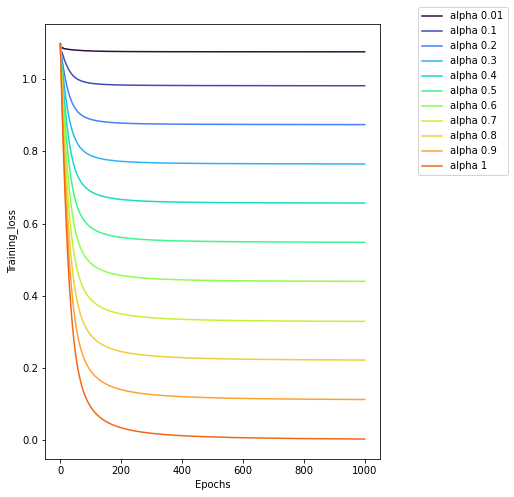

In [24]:
alpha = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
cm = plt.get_cmap('turbo')
fig = plt.figure(figsize=(6,8))
for i,j in enumerate(train_loss_all):
    plt.plot(j,label ="alpha "+str(alpha[i]),color = cm(i*20))

plt.xlabel("Epochs")
plt.ylabel("Training_loss")

plt.legend(bbox_to_anchor=(1.1, 1.05))

Text(0.5, 1.0, 'alpha_=alpha+0.01')

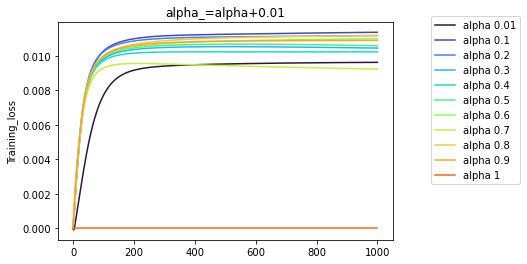

In [25]:
for i in range(len(train_loss_all)):
    temp = np.array(train_loss_all[i]) - np.array(train_loss_alpha_h_all[i])  
    plt.plot(temp,label ="alpha "+str(alpha[i]),color = cm(i*20))
    plt.ylabel("Training_loss")
    plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("alpha_=alpha+0.01")

In [26]:
# train_loss_alpha_h_all[1]

In [27]:
# train_loss_all[1]